In order to make some analysis, we need to set our environment up. To do this, I firstly imported some modules and read data. The below output is the head of the data but if you want to see more details, you might try removing ***#*** signs in front of the ***df.describe()*** and ***df.info()***.  

Further, I defined an empty dataframe. This dataframe includes **Root Mean Squared Error (RMSE), R-squared, Adjusted R-squared** and **mean of the R-squared values obtained by the k-Fold Cross Validation**, which are the important metrics to compare different models. Having a **R-squared value closer to one** and **smaller RMSE** means a better fit. In the following sections, I will fill this dataframe with my results.

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import folium
from folium.plugins import HeatMap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

evaluation = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

df = pd.read_csv('kc_house_data.csv')
#df.describe()
#df.info()
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7.129301e+09,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6.414100e+09,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5.631500e+09,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2.487201e+09,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1.954401e+09,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# <span id="3"></span> Defining a Function to Calculate the Adjusted $R^{2}$

<hr/>

The R-squared increases when the number of features increase. Because of this, sometimes a more robust evaluator is preferred to compare the performance between different models. This evaluater is called adjusted R-squared and it only increases, if the addition of the variable reduces the MSE. The definition of the adjusted $R^{2}$ is:

$\bar{R^{2}}=R^{2}-\frac{k-1}{n-k}(1-R^{2})$

where $n$ is the number of observations and $k$ is the number of parameters. 

In [2]:
def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

# <span id="4"></span> Creating a Simple Linear Regression

<hr/>

When we model a linear relationship between a response and **just one** explanatory variable, this is called **simple linear regression**. I want to predict house prices and then, our response variable is price. However, for a simple model we also need to select a feature. When I look at the columns of the dataset, living area (sqft) seemed the most important feature. When we examine the  <a href=#7>correlation matrix</a>, we may observe that price has the highest correlation coefficient with living area (sqft) and this also supports my opinion. Thus, I decided to use **living area (sqft)** as feature but if you want to examine the relationship between price and another feature, you may prefer that feature.

In [3]:
#%%capture
train_data,test_data = train_test_split(df,train_size = 0.8,random_state=3)

lr = linear_model.LinearRegression()
X_train = np.array(train_data['sqft_living'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['sqft_living'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,df[['sqft_living']],df['price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))

r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression','-',rmsesm,rtrsm,'-',rtesm,'-',cv]
evaluation

Average Price for Test Data: 541086.252
Intercept: -42703.22346464335
Coefficient: [279.85336854]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,264648.146,0.494,-,0.489,-,0.492


[](http://)I also printed the intercept and coefficient for the simple linear regression. By using these values and the below definition, we can estimate the house prices manually. The equation we use for our estimations is called hypothesis function and defined as

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x$$

## <span id="5"></span> Let's Show the Result

Since we have just **two** dimensions at the simple regression, it is **easy to draw** it. The below chart determines the result of the simple regression. It does not look like a perfect fit but when we work with real world datasets, having a perfect fit is not easy.

In [4]:
sns.set(style="white", font_scale=1)

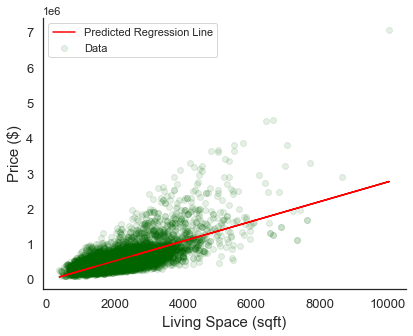

In [5]:
plt.figure(figsize=(6.5,5))
plt.scatter(X_test,y_test,color='darkgreen',label="Data", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Living Space (sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# <span id="6"></span> Visualizing and Examining Data

<hr/>

This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. Drawing charts and examining the data before applying a model is a very good practice because we may detect some possible outliers or decide to do normalization. This is not a must but get know the data is always good. Then, I started with the histograms of dataframe.

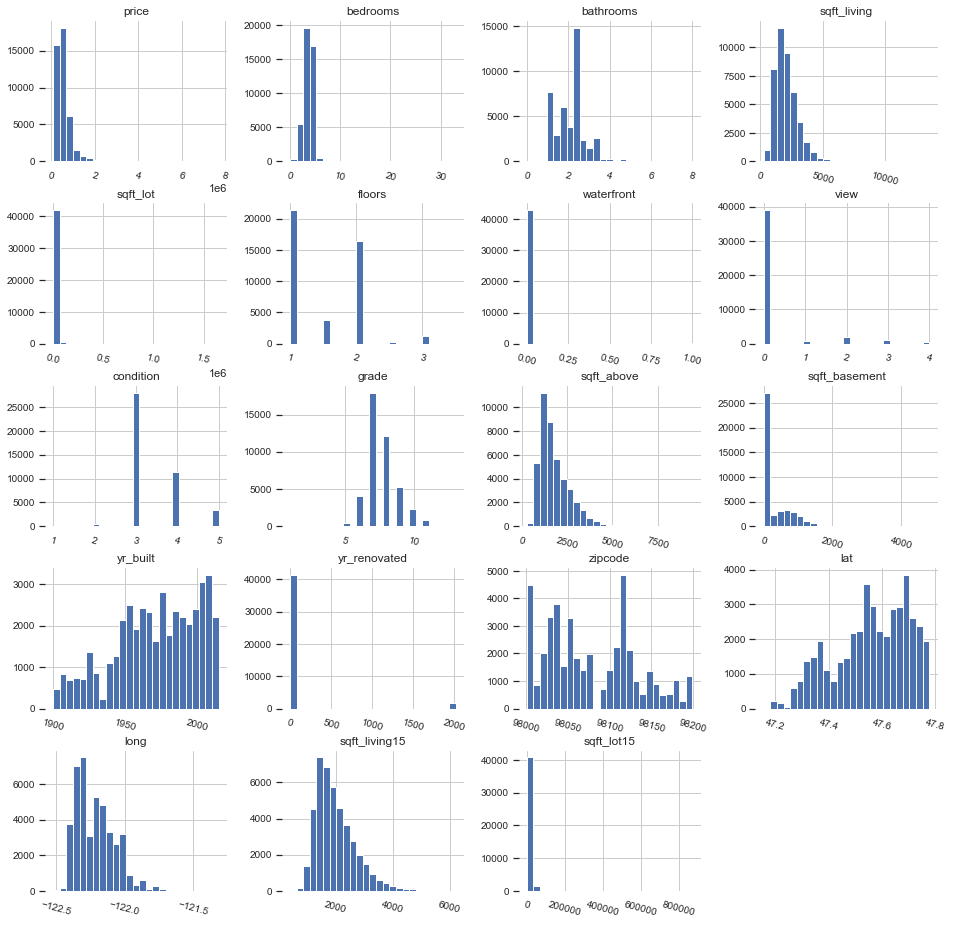

In [6]:
df1=df[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]
h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

To determine bedrooms, floors or bathrooms/bedrooms vs price, I preferred **boxplot** because we have numerical data but they are not continuous as 1,2,... bedrooms, 2.5, 3,... floors (probably 0.5 stands for the penthouse). 

From the below charts, it can be seen that there are very few houses which have some features or price appears far from others like 33 bedrooms or price around 7000000. However, determining their possible negative effect will be time consuming and in the real data sets there will always be some outliers like some luxury house prices in this dataset. That's why I am not planning to remove outliers.

In [7]:
sns.set(style="whitegrid", font_scale=1)

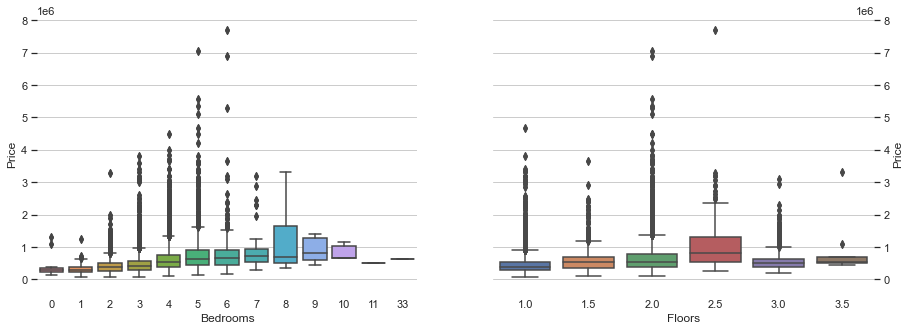

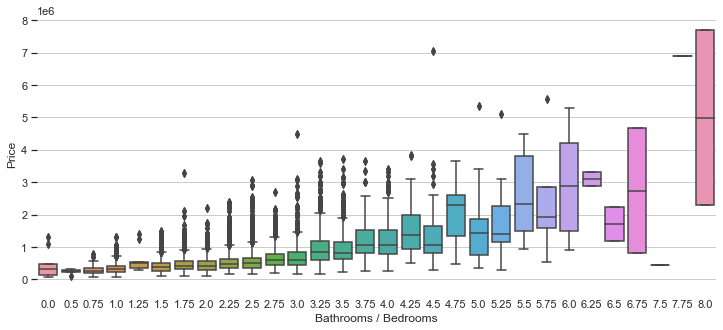

In [8]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['bedrooms'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['floors'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df['bathrooms'],y=df['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price');

I drew the price vs some features and it seems that there is not a perfect linear relationship between the price and these features. On the other hand, what about the relationship among each other? To show this, I preferred 3D plots. Also, I used light green as the  point color. Dark green parts mean high density, many light green points overlap and become darker. 

The below charts show that when the sqrt_living increases, sqrt_lot and bedrooms or bathrooms/bedrooms increases. However, the floors, bedrooms and bathrooms/bedrooms or sqrt_living does not have a similar relationship.  

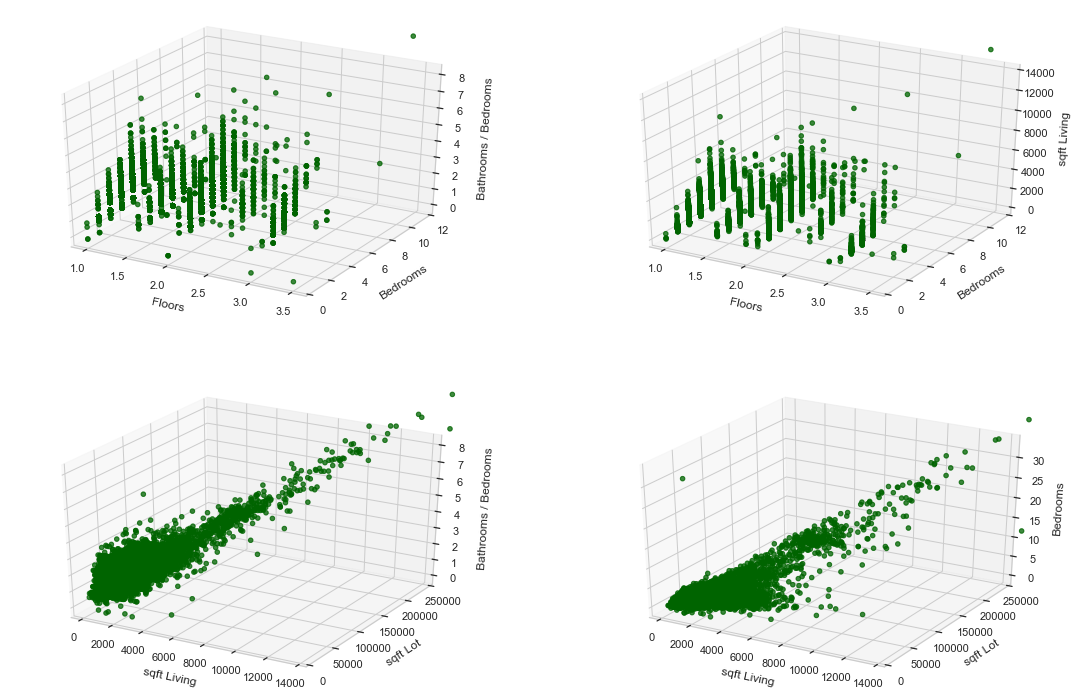

In [9]:
fig=plt.figure(figsize=(19,12.5))
ax=fig.add_subplot(2,2,1, projection="3d")
ax.scatter(df['floors'],df['bedrooms'],df['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nBathrooms / Bedrooms')
ax.set(ylim=[0,12])

ax=fig.add_subplot(2,2,2, projection="3d")
ax.scatter(df['floors'],df['bedrooms'],df['sqft_living'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nFloors',ylabel='\nBedrooms',zlabel='\nsqft Living')
ax.set(ylim=[0,12])

ax=fig.add_subplot(2,2,3, projection="3d")
ax.scatter(df['sqft_living'],df['sqft_lot'],df['bathrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='\nBathrooms / Bedrooms')
ax.set(ylim=[0,250000])

ax=fig.add_subplot(2,2,4, projection="3d")
ax.scatter(df['sqft_living'],df['sqft_lot'],df['bedrooms'],c="darkgreen",alpha=.5)
ax.set(xlabel='\n sqft Living',ylabel='\nsqft Lot',zlabel='Bedrooms')
ax.set(ylim=[0,250000]);

Let's visualize more features. When we look at the below boxplots, grade and waterfront effect price visibly. On the other hand, view seem to effect less but it also has an effect on price. 

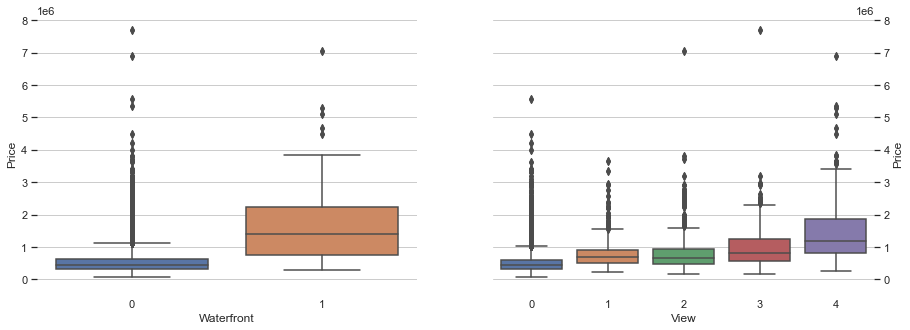

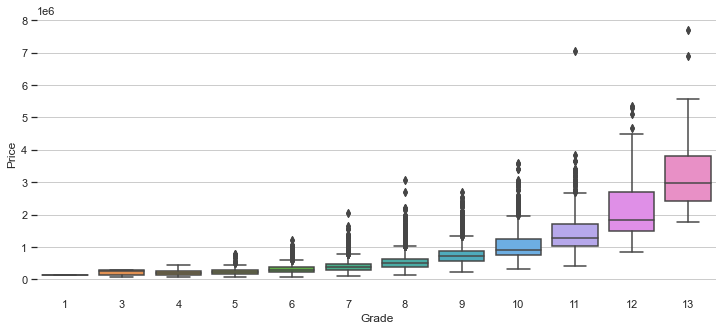

In [10]:
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df['waterfront'],y=df['price'], ax=axes[0])
sns.boxplot(x=df['view'],y=df['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.boxplot(x=df['grade'],y=df['price'], ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price');

Further, I drew the 3D plot to determine the relation between the view, grade and year built. The below chart shows that the newer houses have better grades but we can not say much about the change in the view.  

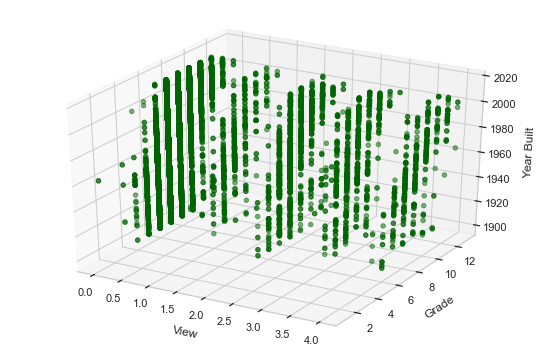

In [11]:
fig=plt.figure(figsize=(9.5,6.25))
ax=fig.add_subplot(1,1,1, projection="3d")
ax.scatter(train_data['view'],train_data['grade'],train_data['yr_built'],c="darkgreen",alpha=.5)
ax.set(xlabel='\nView',ylabel='\nGrade',zlabel='\nYear Built');

In [ ]:
zipcode=98001,98002

In this dataset, we have latitude and longtitude information for the houses. By using *lat* and *long* columns, I displayed the below heat map which is very useful for the people who does not know Seattle well. Also, if you select a spesific zip code, you may just see the heat map of this zip code's neighborhood.

In [3]:
df2=df.copy()
df2.sort_values(by=['zipcode'], inplace = True)
df2.set_index( "zipcode", inplace=True )
df2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
zipcode,,,,,,,,,,,,,,,,,,,,
98001,7.967000e+09,20141121T000000,345500.0,3,2.5,1930,4000,2.0,0,0,3,8,1930,0,2014,0,47.3518,-122.275,2050,4000
98001,3.874010e+09,20140624T000000,289000.0,3,2.5,1970,9607,2.0,0,0,3,7,1090,880,1988,0,47.3462,-122.286,2020,9608
98001,7.696610e+09,20141229T000000,238000.0,3,1.5,1360,7488,1.0,0,0,4,7,1050,310,1975,0,47.3314,-122.275,1580,7508
98001,4.031000e+09,20150408T000000,195000.0,3,1.0,1310,9554,1.0,0,0,3,7,960,350,1962,0,47.2949,-122.285,1310,9845
98001,3.329520e+09,20140521T000000,250000.0,3,2.0,1170,7258,1.0,0,0,3,7,1170,0,1984,0,47.3333,-122.266,1410,7750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98199,2.770602e+09,20140630T000000,535000.0,3,1.0,1580,6300,1.0,0,0,3,7,1180,400,1925,0,47.6505,-122.384,1560,1601
98199,3.271300e+09,20150323T000000,1028000.0,3,3.0,2800,5800,1.0,0,0,3,9,1580,1220,1953,2010,47.6493,-122.413,2580,5800
98199,8.710001e+08,20141120T000000,419000.0,2,1.0,720,4592,1.0,0,0,4,6,720,0,1943,0,47.6534,-122.404,1030,5816


In [4]:
df2=df2.groupby(['zipcode']).mean()
df2

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
zipcode,,,,,,,,,,,,,,,,,,,
98001,4.664787e+09,2.808047e+05,3.383978,2.006215,1900.856354,14937.450276,1.429558,0.000000,0.102210,3.337017,7.295580,1721.325967,179.530387,1980.679558,43.801105,47.309020,-122.270646,1828.856354,11214.403315
98002,4.850894e+09,2.342840e+05,3.326633,1.839196,1627.743719,7517.633166,1.334171,0.000000,0.010050,3.743719,6.693467,1522.537688,105.206030,1967.773869,59.889447,47.308780,-122.213357,1479.030151,7585.482412
98003,4.674182e+09,2.941113e+05,3.357143,2.047321,1928.882143,10603.096429,1.310714,0.000000,0.214286,3.371429,7.542857,1663.550000,265.332143,1976.885714,21.360714,47.315741,-122.310054,1876.196429,9746.178571
98004,4.394237e+09,1.355927e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,0.003155,0.305994,3.495268,8.687697,2419.842271,489.179811,1971.470032,208.145110,47.616183,-122.205189,2674.700315,12805.022082
98005,4.961872e+09,8.101649e+05,3.851190,2.424107,2656.803571,19928.785714,1.279762,0.000000,0.095238,3.696429,8.488095,2160.196429,496.607143,1969.744048,47.630952,47.611532,-122.167268,2567.863095,18367.773810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98177,3.934998e+09,6.761854e+05,3.396078,2.100000,2323.333333,11904.403922,1.276471,0.003922,0.815686,3.494118,7.976471,1836.713725,486.619608,1960.843137,172.145098,47.742381,-122.369282,2186.196078,11690.239216
98178,4.291467e+09,3.106128e+05,3.305344,1.731870,1729.351145,8309.122137,1.185115,0.034351,0.534351,3.320611,6.816794,1325.992366,403.358779,1955.232824,84.057252,47.499118,-122.246969,1648.816794,8149.641221
98188,4.481851e+09,2.890783e+05,3.433824,1.863971,1802.772059,10126.080882,1.227941,0.000000,0.147059,3.330882,7.036765,1492.154412,310.617647,1965.507353,43.794118,47.447310,-122.280993,1636.279412,9752.801471


In [4]:
df2_split = np.array_split(df2, 7)
df2_split[6].groupby(['zipcode']).mean()
#df2_split

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
zipcode,,,,,,,,,,,,,,,,,,,
98146,4.607855e+09,359483.239583,3.125000,1.633681,1621.451389,9020.243056,1.222222,0.027778,0.402778,3.291667,6.822917,1374.854167,246.597222,1955.791667,179.190972,47.502055,-122.358306,1535.375000,8263.704861
98148,5.579459e+09,284908.596491,3.140351,1.793860,1610.526316,8960.719298,1.210526,0.000000,0.000000,3.070175,6.947368,1486.491228,124.035088,1963.263158,34.596491,47.437437,-122.329316,1611.228070,8812.385965
98155,4.748531e+09,423725.695067,3.322870,1.815022,1786.614350,10284.674888,1.218610,0.013453,0.170404,3.473094,7.170404,1478.071749,308.542601,1961.136771,80.641256,47.754863,-122.303540,1716.710762,9812.881166
98166,4.043990e+09,464231.838583,3.377953,1.911417,2067.905512,13609.397638,1.250000,0.059055,0.665354,3.574803,7.393701,1705.472441,362.433071,1957.622047,196.452756,47.455212,-122.350303,1886.850394,12694.322835
98168,3.204785e+09,240328.371747,2.996283,1.433086,1468.624535,11269.843866,1.159851,0.000000,0.014870,3.245353,6.509294,1234.089219,234.535316,1952.721190,59.052045,47.489700,-122.307877,1471.680297,9744.022305
98177,3.934998e+09,676185.392157,3.396078,2.100000,2323.333333,11904.403922,1.276471,0.003922,0.815686,3.494118,7.976471,1836.713725,486.619608,1960.843137,172.145098,47.742381,-122.369282,2186.196078,11690.239216
98178,4.291467e+09,310612.755725,3.305344,1.731870,1729.351145,8309.122137,1.185115,0.034351,0.534351,3.320611,6.816794,1325.992366,403.358779,1955.232824,84.057252,47.499118,-122.246969,1648.816794,8149.641221
98188,4.481851e+09,289078.345588,3.433824,1.863971,1802.772059,10126.080882,1.227941,0.000000,0.147059,3.330882,7.036765,1492.154412,310.617647,1965.507353,43.794118,47.447310,-122.280993,1636.279412,9752.801471
98198,5.152291e+09,302878.882143,3.182143,1.788393,1745.360714,10525.978571,1.225000,0.035714,0.592857,3.442857,7.103571,1476.253571,269.107143,1966.735714,85.492857,47.390788,-122.315743,1711.571429,9478.596429


In [ ]:
# find the row of the house which has the highest price
maxpr=df.loc[df['price'].idxmax()]
minpr=df.loc[df['price'].idxmin()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=11.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = df.copy()
# select a zipcode for the heatmap
#set(df['zipcode'])
#df_copy = df[df['zipcode']==98002].copy()
#df_copy = df[df['zipcode']==98177].copy()
#df_copy=df2_split[5].copy()
df_copy['count'] = 1

basemap = generateBaseMap()
# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
folium.Marker([minpr['lat'], minpr['long']],popup='Lowest Price: $'+str(format(minpr['price'],'.0f')),
              icon=folium.Icon(color='red')).add_to(s)
# add heatmap
HeatMap(data=df_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)

basemap.add_child(folium.LatLngPopup())


basemap

In [72]:
#idee
#Perché stai calcolando dei parametri attraverso il parametro che devi predirre, ovvero il prezzo
#trovare macrozone di seattle con zipcode?!?!
#clusterizzare per lat e long?!?!?
#Fare cluster su lat long sconsiglio, rischi di mettere insieme bronx e manhattan tipo

print(df.lat.min(),"lat minima")
print(df.lat.max(),"lat massima")
print(df.long.min(),"long minima")
print(df.long.max(),"long massima")

print(df.lat.max()-df.lat.min(),"differenza latitudine")
print(df.long.max()-df.long.min(),"differenza longitudine")

47.1559 lat minima
47.7776 lat massima
-122.519 long minima
-121.315 long massima
0.621699999999997 differenza latitudine
1.2040000000000077 differenza longitudine


In [20]:
# find the row of the house which has the highest price
maxpr=df.loc[df['price'].idxmax()]
minpr=df.loc[df['price'].idxmin()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = df.copy()
# select a zipcode for the heatmap
#set(df['zipcode'])
#df_copy = df[df['zipcode']==98002].copy()
#df_copy = df[df['zipcode']==98019].copy()
#df_copy=df2_split[2].copy()
df_copy['count'] = 1

basemap = generateBaseMap()
# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
folium.Marker([minpr['lat'], minpr['long']],popup='Lowest Price: $'+str(format(minpr['price'],'.0f')),
              icon=folium.Icon(color='red')).add_to(s)
# add heatmap
HeatMap(data=df_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)

basemap.add_child(folium.LatLngPopup())

folium.Rectangle([(47.1559,-122.519), (47.2000,-122.500)]).add_to(basemap)


folium.CircleMarker(
    location=[47.2977, -122.2713],
    radius=30,
    popup="98001",
    color="#3186cc",
    fill=True,
    fill_color="#3186cc",
).add_to(basemap)

basemap

## <span id="7"></span> Checking Out the Correlation Among Explanatory Variables

Having too many features in a model is not always a good thing because it might cause overfitting and worser results when we want to predict values for a new dataset. Thus, **if a feature does not improve your model a lot, not adding it may be a better choice**.

Another important thing is correlation. **If there is very high correlation between two features, keeping both of them is not a good idea most of the time not to cause overfitting**. For instance, if there is overfitting, we may remove sqt_above or sqt_living because they are highly correlated. This relation can be estimated when we look at the definitions in the dataset but to be sure correlation matrix should be checked. However, this does not mean that you must remove one of the highly correlated features. For example: bathrooms and sqrt_living. They are highly correlated but I do not think that the relation among them is the same as the relation between sqt_living and sqt_above.

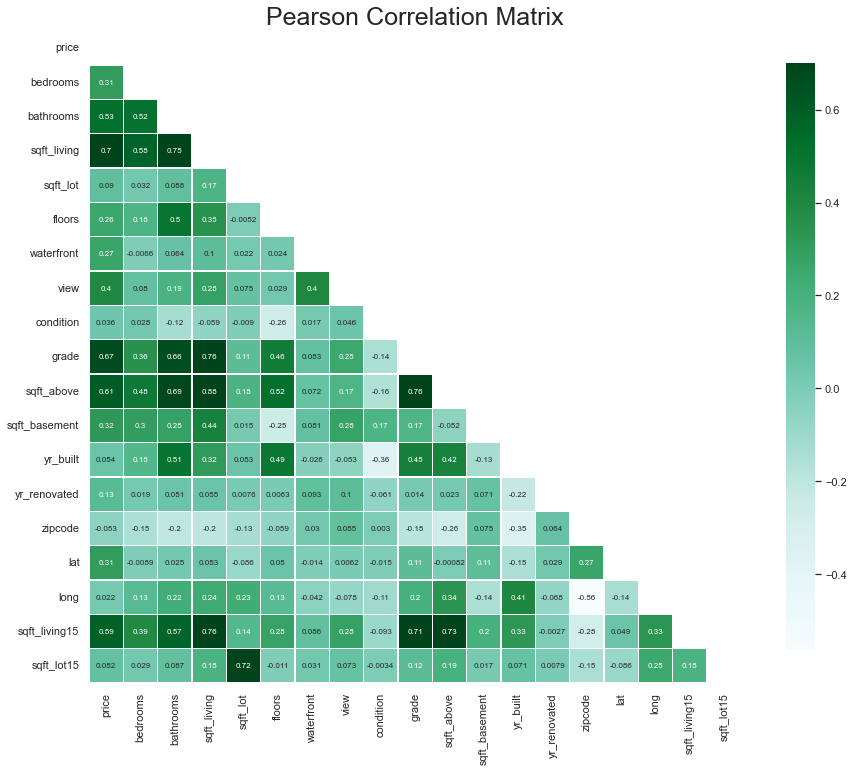

In [14]:
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# <span id="8"></span> Data Preprocessing

<hr/>

A preprocessing on data might improve the model accuracy and make the model more reliable. It does not always have to improve our results but when we are conscious of the features and use a proper input, we might reach some outcomes easier. I tried various data mining techniques like transformation or normalization but in the end, decided to just use binning and created a new dataframe called ***df_dm***.

In [15]:
df_dm=df.copy()
df_dm.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,4.322600e+04,4.322600e+04,43226.000000,43226.000000,43226.000000,4.322600e+04,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000,43226.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876532e+09,3.671229e+05,0.930051,0.770154,918.430273,4.142003e+04,0.539983,0.086516,0.766309,0.650736,1.175445,828.081399,442.569923,29.373071,401.674594,53.504407,0.138562,0.140827,685.383376,27303.863792
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## <span id="9"></span> Binning

Data binning is a preprocessing technique used to reduce the effects of minor observation errors. I think it is worthwhile applying to some columns of this dataset. I applied binning to *yr_built* and *yr_renovated*. I added the ages and renovation ages of the houses when they were sold. Also, I partitioned these columns to intervals and you can observe this in the below **histograms**. 

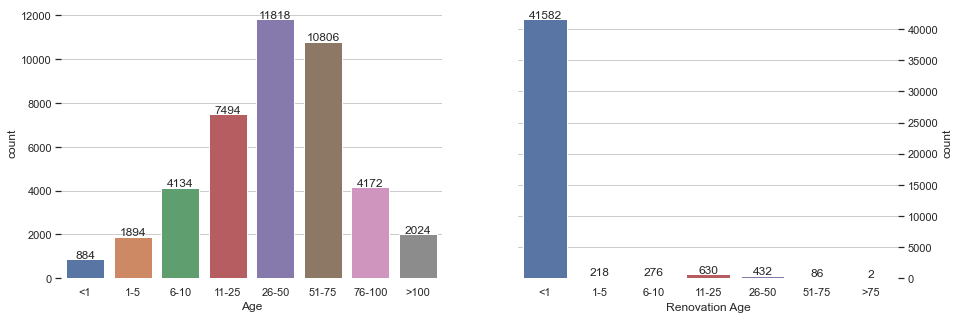

In [16]:
# just take the year from the date column
df_dm['sales_yr']=df_dm['date'].astype(str).str[:4]

# add the age of the buildings when the houses were sold as a new column
df_dm['age']=df_dm['sales_yr'].astype(int)-df_dm['yr_built']
# add the age of the renovation when the houses were sold as a new column
df_dm['age_rnv']=0
df_dm['age_rnv']=df_dm['sales_yr'][df_dm['yr_renovated']!=0].astype(int)-df_dm['yr_renovated'][df_dm['yr_renovated']!=0]
df_dm['age_rnv'][df_dm['age_rnv'].isnull()]=0

# partition the age into bins
bins = [-2,0,5,10,25,50,75,100,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','76-100','>100']
df_dm['age_binned'] = pd.cut(df_dm['age'], bins=bins, labels=labels)
# partition the age_rnv into bins
bins = [-2,0,5,10,25,50,75,100000]
labels = ['<1','1-5','6-10','11-25','26-50','51-75','>75']
df_dm['age_rnv_binned'] = pd.cut(df_dm['age_rnv'], bins=bins, labels=labels)

# histograms for the binned columns
f, axes = plt.subplots(1, 2,figsize=(15,5))
p1=sns.countplot(df_dm['age_binned'],ax=axes[0])
for p in p1.patches:
    height = p.get_height()
    p1.text(p.get_x()+p.get_width()/2,height + 50,height,ha="center")   
p2=sns.countplot(df_dm['age_rnv_binned'],ax=axes[1])
sns.despine(left=True, bottom=True)
for p in p2.patches:
    height = p.get_height()
    p2.text(p.get_x()+p.get_width()/2,height + 200,height,ha="center")
    
axes[0].set(xlabel='Age')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Renovation Age');

# transform the factor values to be able to use in the model
df_dm = pd.get_dummies(df_dm, columns=['age_binned','age_rnv_binned'])

# <span id="10"></span> Multiple Regression
<hr/>

I used a <a href=#4>simple linear regression</a> and found a poor fit. In order to improve this model I am planing to add more features. When we have **more than one** feature in a linear regression, it is defined as **multiple regression**. Then, it is time to create some complex models.

## <span id="11"></span> Multiple Regression - 1

I determined ***features*** at first sight by looking at the previous sections and used in my first multiple linear regression. As in the simple regression, I printed the coefficients which the model uses for the predictions. However, this time we must use the below definition for our predictions, if we want to make calculations manually.

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+...+\theta_{n}x_{n}$$

In [17]:
train_data_dm,test_data_dm = train_test_split(df_dm,train_size = 0.8,random_state=3)

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','zipcode']
complex_model_1 = linear_model.LinearRegression()
complex_model_1.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_1.intercept_))
print('Coefficients: {}'.format(complex_model_1.coef_))

pred = complex_model_1.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_1.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_1.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_1.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_1.score(test_data_dm[features],test_data['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_1,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-1','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: -53181145.81359801
Coefficients: [-5.56342561e+04  1.15079447e+04  3.14041455e+02 -2.75744391e-01
 -3.81244265e+03  5.42837440e+02]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
1,Multiple Regression-1,selected features,257222.494,0.514,0.514,0.518,0.517,0.514
0,Simple Linear Regression,-,264648.146,0.494,-,0.489,-,0.492


## <span id="12"></span> Multiple Regression - 2

In addition to the previous subsection, I added more features to the ***features*** list. Also, I printed the coefficients of the model as in the previous subsection. When we look at the evaluation metrics, they improved significantly.

In [18]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
             'grade','age_binned_<1', 'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 
             'age_binned_26-50', 'age_binned_51-75','age_binned_76-100', 'age_binned_>100',
             'zipcode']
complex_model_2 = linear_model.LinearRegression()
complex_model_2.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_2.intercept_))
print('Coefficients: {}'.format(complex_model_2.coef_))

pred = complex_model_2.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_2.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_2.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_2.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_2.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_2,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-2','selected features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 17527615.481823023
Coefficients: [-3.60606050e+04  4.62581759e+04  1.71149504e+02 -2.00335809e-01
  1.28145357e+04  5.39319809e+05  4.93177061e+04  1.22701414e+05
 -8.46605489e+04 -1.04555979e+05 -1.01225029e+05 -1.37437495e+05
 -5.42243175e+04  8.43044845e+04  1.86427279e+05  2.11371606e+05
 -1.86437818e+02]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
2,Multiple Regression-2,selected features,214160.493,0.650,0.65,0.666,0.665,0.652
1,Multiple Regression-1,selected features,257222.494,0.514,0.514,0.518,0.517,0.514
0,Simple Linear Regression,-,264648.146,0.494,-,0.489,-,0.492


## <span id="13"></span> Multiple Regression - 3

In order to observe differences easily, I created a model with all features without any preprossing. Evaluation metrics improved remarkable again.  

In [19]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_3 = linear_model.LinearRegression()
complex_model_3.fit(train_data[features],train_data['price'])

print('Intercept: {}'.format(complex_model_3.intercept_))
print('Coefficients: {}'.format(complex_model_3.coef_))

pred = complex_model_3.predict(test_data[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_3.score(train_data[features],train_data['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_3.score(train_data[features],train_data['price']),train_data.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_3.score(test_data[features],test_data['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_3.score(test_data[features],test_data['price']),test_data.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_3,df[features],df['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-3','all features, no preprocessing',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 10091614.242146937
Coefficients: [-3.42565560e+04  3.98122088e+04  1.11670630e+02  1.62086453e-01
  9.58921093e+03  5.48396250e+05  5.53191859e+04  2.65590825e+04
  9.55830684e+04  6.96200535e+01  4.20505765e+01 -2.64510196e+03
  2.07944962e+01 -6.13345188e+02  6.04065915e+05 -2.11594819e+05
  1.88872198e+01 -4.05187276e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
3,Multiple Regression-3,"all features, no preprocessing",198502.394,0.696,0.696,0.713,0.712,0.698
2,Multiple Regression-2,selected features,214160.493,0.650,0.65,0.666,0.665,0.652
1,Multiple Regression-1,selected features,257222.494,0.514,0.514,0.518,0.517,0.514
0,Simple Linear Regression,-,264648.146,0.494,-,0.489,-,0.492


## <span id="14"></span> Multiple Regression - 4

This time I used the data obtained after preprocessing step.

In [20]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_4 = linear_model.LinearRegression()
complex_model_4.fit(train_data_dm[features],train_data_dm['price'])

print('Intercept: {}'.format(complex_model_4.intercept_))
print('Coefficients: {}'.format(complex_model_4.coef_))

pred = complex_model_4.predict(test_data_dm[features])
rmsecm = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred)),'.3f'))
rtrcm = float(format(complex_model_4.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm = float(format(adjustedR2(complex_model_4.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm = float(format(complex_model_4.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm = float(format(adjustedR2(complex_model_4.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_4,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression-4','all features',rmsecm,rtrcm,artrcm,rtecm,artecm,cv]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

Intercept: 12426223.424926868
Coefficients: [-3.24361882e+04  3.50565693e+04  1.11646603e+02  1.72741864e-01
 -1.01255960e+04  5.57439466e+05  5.68226172e+04  3.32670994e+04
  9.48384059e+04  6.99783396e+01  4.16680381e+01 -3.87394029e+04
 -5.18265814e+04 -6.71291455e+04 -8.99517165e+04 -6.10253491e+04
  3.61093706e+04  1.23733594e+05  1.48829231e+05 -1.15227530e+04
  1.20315953e+05  8.44987397e+04  5.07544234e+04 -2.41527319e+04
 -1.41989837e+05 -7.79037943e+04 -6.89026594e+02  6.08421651e+05
 -2.09177499e+05  2.01229852e+01 -3.39785634e-01]


,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,197836.958,0.700,0.7,0.715,0.714,0.702
3,Multiple Regression-3,"all features, no preprocessing",198502.394,0.696,0.696,0.713,0.712,0.698
2,Multiple Regression-2,selected features,214160.493,0.650,0.65,0.666,0.665,0.652
1,Multiple Regression-1,selected features,257222.494,0.514,0.514,0.518,0.517,0.514
0,Simple Linear Regression,-,264648.146,0.494,-,0.489,-,0.492


# <span id="15"></span> Regularization
#### [Return Contents](#0)
<hr/>

**Regularization** is designed to address the problem of overfitting and undefitting. **Overfitting** means high variance and is usually caused by a complicated function that creates a lot of unnecessary curves and angles unrelated to the data. This function fits training data well but might cause poor results for the test set. On the other hand, **underfitting** means low variance and a very simple model. This might also cause poor results too. **Possible remedies** are adjusting features manually or using some model selection algoritms which brings an extra workload. Conversely, when we apply regularization, all the features are kept and the model adjusts $\theta_{j}$. This especially works when we have a lot of slightly useful features. There are two widely used regularization types (Ridge and Lasso Regressions) and in this section, I used them.

**When to use ridge vs lasso regression:**
*  Many small/medium sized effects: use *ridge*.
*  Only a few variables with medium/large effect: use *lasso*.


## <span id="16"></span> Ridge Regression

Ridge regression is called **L2 regularization** and by adding a penalty, we obtain the below equation

$$RSS_{RIDGE} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}\theta^{2}_{j}$$

By changing the $\alpha$ value, we can control the amount of the regularization. When we increase $\alpha$, regularization increases and the opposite is valid too. As a result of this, I selected different $\alpha$ values and used a linear regression without regularization in order to observe the differences easily.

In [21]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_R = linear_model.Ridge(alpha=1)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_R.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=100)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_R.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=1000)
complex_model_R.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_R.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Ridge Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Ridge Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,197836.958,0.700,0.7,0.715,0.714,0.702
5,Ridge Regression,"alpha=1, all features",197848.352,0.700,0.7,0.715,0.714,0.702
6,Ridge Regression,"alpha=100, all features",199721.528,0.697,0.697,0.709,0.708,0.699
3,Multiple Regression-3,"all features, no preprocessing",198502.394,0.696,0.696,0.713,0.712,0.698
7,Ridge Regression,"alpha=1000, all features",211096.058,0.667,0.667,0.675,0.674,0.668
2,Multiple Regression-2,selected features,214160.493,0.650,0.65,0.666,0.665,0.652
1,Multiple Regression-1,selected features,257222.494,0.514,0.514,0.518,0.517,0.514
0,Simple Linear Regression,-,264648.146,0.494,-,0.489,-,0.492


## <span id="17"></span> Lasso Regression

Lasso regression is called **L1 regularization** and it is defined as

$$RSS_{LASSO} = \sum_{i=1}^{m}(h_{\theta}(x_{i})-y_{i})^{2} + \alpha \sum_{j=1}^{n}|\theta_{j}|$$

The main difference between ridge and lasso is the penalty but $\alpha$ works the same way.   

In [22]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
complex_model_L = linear_model.Lasso(alpha=1)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred1 = complex_model_L.predict(test_data_dm[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=100)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred2 = complex_model_L.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=1000)
complex_model_L.fit(train_data_dm[features],train_data_dm['price'])

pred3 = complex_model_L.predict(test_data_dm[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_L.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_L.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_L.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_L.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_L,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso Regression','alpha=1, all features',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Lasso Regression','alpha=100, all features',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Lasso Regression','alpha=1000, all features',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
4,Multiple Regression-4,all features,197836.958,0.700,0.7,0.715,0.714,0.702
5,Ridge Regression,"alpha=1, all features",197848.352,0.700,0.7,0.715,0.714,0.702
8,Lasso Regression,"alpha=1, all features",197837.220,0.700,0.7,0.715,0.714,0.702
9,Lasso Regression,"alpha=100, all features",197892.951,0.700,0.7,0.714,0.713,0.702
6,Ridge Regression,"alpha=100, all features",199721.528,0.697,0.697,0.709,0.708,0.699
3,Multiple Regression-3,"all features, no preprocessing",198502.394,0.696,0.696,0.713,0.712,0.698
10,Lasso Regression,"alpha=1000, all features",199879.457,0.696,0.696,0.709,0.708,0.698
7,Ridge Regression,"alpha=1000, all features",211096.058,0.667,0.667,0.675,0.674,0.668
2,Multiple Regression-2,selected features,214160.493,0.650,0.65,0.666,0.665,0.652
1,Multiple Regression-1,selected features,257222.494,0.514,0.514,0.518,0.517,0.514


# <span id="18"></span> Polynomial Regression
#### [Return Contents](#0)
<hr/>

For the linear models, the main idea is to fit a straight line to our data. However, if the data has a quadratic distribution, this time choosing a quadratic function and applying a polynomial transformation may give us better results. This time the hypothesis function is defined as

$$h_{\theta}(X)=\theta_{0}+\theta_{1}x+\theta_{2}x^{2}+...+\theta_{n}x^{n}$$

Since there are many variations for the polynomial regression, I prefered to show results by a new table and it can be seen from the below table that polynomial transformation improved the model fit a lot. On the other hand, while using polynomial transformation and deciding to degree, we should be very careful because it **migh cause overfitting**. Also, in the below table overfitting exists for some models. The 5-fold cross validation metrics are negative or low for these models although they have very high R-squared values for the training set.

In [ ]:
evaluation_poly = pd.DataFrame({'Model': [],
                                'Details':[],
                                'Root Mean Squared Error (RMSE)':[],
                                'R-squared (training)':[],
                                'Adjusted R-squared (training)':[],
                                'R-squared (test)':[],
                                'Adjusted R-squared (test)':[],
                                '5-Fold Cross Validation':[]})

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
             'grade','yr_built','zipcode']
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred1 = poly.predict(X_testpoly)
rmsepoly1 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred1)),'.3f'))
rtrpoly1 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly1 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv1 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred2 = poly.predict(X_testpoly)
rmsepoly2 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred2)),'.3f'))
rtrpoly2 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly2 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv2 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view',
            'condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred3 = poly.predict(X_testpoly)
rmsepoly3 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred3)),'.3f'))
rtrpoly3 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly3 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv3 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(df[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred4 = poly.predict(X_testpoly)
rmsepoly4 = float(format(np.sqrt(metrics.mean_squared_error(test_data['price'],pred4)),'.3f'))
rtrpoly4 = float(format(poly.score(X_trainpoly,train_data['price']),'.3f'))
rtepoly4 = float(format(poly.score(X_testpoly,test_data['price']),'.3f'))
cv4 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df['price'],cv=5).mean(),'.3f'))


features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['price'])

pred5 = poly.predict(X_testpoly)
rmsepoly5 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred5)),'.3f'))
rtrpoly5 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly5 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv5 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Ridge(alpha=1).fit(X_trainpoly, train_data['price'])

pred6 = poly.predict(X_testpoly)
rmsepoly6 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred6)),'.3f'))
rtrpoly6 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly6 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv6 = float(format(cross_val_score(linear_model.Ridge(alpha=1),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Ridge(alpha=50000).fit(X_trainpoly, train_data['price'])

pred7 = poly.predict(X_testpoly)
rmsepoly7 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred7)),'.3f'))
rtrpoly7 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly7 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv7 = float(format(cross_val_score(linear_model.Ridge(alpha=50000),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Lasso(alpha=1).fit(X_trainpoly, train_data['price'])

pred8 = poly.predict(X_testpoly)
rmsepoly8 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred8)),'.3f'))
rtrpoly8 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly8 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv8 = float(format(cross_val_score(linear_model.Lasso(alpha=1),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df_dm[features])
X_trainpoly = polyfeat.fit_transform(train_data_dm[features])
X_testpoly = polyfeat.fit_transform(test_data_dm[features])
poly = linear_model.Lasso(alpha=50000).fit(X_trainpoly, train_data['price'])

pred9 = poly.predict(X_testpoly)
rmsepoly9 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred9)),'.3f'))
rtrpoly9 = float(format(poly.score(X_trainpoly,train_data_dm['price']),'.3f'))
rtepoly9 = float(format(poly.score(X_testpoly,test_data_dm['price']),'.3f'))
cv9 = float(format(cross_val_score(linear_model.Lasso(alpha=50000),X_allpoly,df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation_poly.shape[0]
evaluation_poly.loc[r] = ['Polynomial Regression','degree=2, selected features, no preprocessing',rmsepoly1,rtrpoly1,'-',rtepoly1,'-',cv1]
evaluation_poly.loc[r+1] = ['Polynomial Regression','degree=3, selected features, no preprocessing',rmsepoly2,rtrpoly2,'-',rtepoly2,'-',cv2]
evaluation_poly.loc[r+2] = ['Polynomial Regression','degree=2, all features, no preprocessing',rmsepoly3,rtrpoly3,'-',rtepoly3,'-',cv3]
evaluation_poly.loc[r+3] = ['Polynomial Regression','degree=3, all features, no preprocessing',rmsepoly4,rtrpoly4,'-',rtepoly4,'-',cv4]
evaluation_poly.loc[r+4] = ['Polynomial Regression','degree=2, all features',rmsepoly5,rtrpoly5,'-',rtepoly5,'-',cv5]
evaluation_poly.loc[r+5] = ['Polynomial Ridge Regression','alpha=1, degree=2, all features',rmsepoly6,rtrpoly6,'-',rtepoly6,'-',cv6]
evaluation_poly.loc[r+6] = ['Polynomial Ridge Regression','alpha=50000, degree=2, all features',rmsepoly7,rtrpoly7,'-',rtepoly7,'-',cv7]
evaluation_poly.loc[r+7] = ['Polynomial Lasso Regression','alpha=1, degree=2, all features',rmsepoly8,rtrpoly8,'-',rtepoly8,'-',cv8]
evaluation_poly.loc[r+8] = ['Polynomial Lasso Regression','alpha=50000, degree=2, all features',rmsepoly9,rtrpoly9,'-',rtepoly9,'-',cv9]
evaluation_poly_temp = evaluation_poly[['Model','Details','Root Mean Squared Error (RMSE)','R-squared (training)','R-squared (test)','5-Fold Cross Validation']]
evaluation_poly_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)

# <span id="19"></span> k-NN Regression 
#### [Return Contents](#0)
<hr/>

I included k-NN regression in this kernel but actually, I did not expect to obtain a good result by using it. Also, k-NN does not give much insight. It is a very simple method and the idea behind the algorithm is similar to the k-NN classification. Briefly, it uses the weighted average, median or another statistic you want of k-nearest instances.

The evaluation metrics for the training, test sets and different *k* values were given in the below table. It can be seen that, k-NN was not very successful as expected. 

In [ ]:
features = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','age_binned_<1', 
            'age_binned_1-5', 'age_binned_6-10','age_binned_11-25', 'age_binned_26-50',
            'age_binned_51-75','age_binned_76-100', 'age_binned_>100','age_rnv_binned_<1',
            'age_rnv_binned_1-5', 'age_rnv_binned_6-10', 'age_rnv_binned_11-25',
            'age_rnv_binned_26-50', 'age_rnv_binned_51-75', 'age_rnv_binned_>75',
            'zipcode','lat','long','sqft_living15','sqft_lot15']
knnreg = KNeighborsRegressor(n_neighbors=15)
knnreg.fit(train_data_dm[features],train_data_dm['price'])
pred = knnreg.predict(test_data_dm[features])

rmseknn1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn1 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn1 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn1 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn1 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

knnreg = KNeighborsRegressor(n_neighbors=25)
knnreg.fit(train_data_dm[features],train_data_dm['price'])
pred = knnreg.predict(test_data_dm[features])

rmseknn2 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn2 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn2 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn2 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn2 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

knnreg = KNeighborsRegressor(n_neighbors=27)
knnreg.fit(train_data_dm[features],train_data_dm['price'])
pred = knnreg.predict(test_data_dm[features])

rmseknn3 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn3 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn3 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn3 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn3 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['KNN Regression','k=15, all features',rmseknn1,rtrknn1,artrknn1,rteknn1,arteknn1,cv1]
evaluation.loc[r+1] = ['KNN Regression','k=25, all features',rmseknn2,rtrknn2,artrknn2,rteknn2,arteknn2,cv2]
evaluation.loc[r+2] = ['KNN Regression','k=27, all features',rmseknn3,rtrknn3,artrknn3,rteknn3,arteknn3,cv3]
evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

# <span id="20"></span> Evaluation Table
#### [Return Contents](#0)
<hr/>

In [ ]:
evaluation_temp=evaluation.append(evaluation_poly)
evaluation_temp1=evaluation_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)
evaluation_temp2=evaluation_temp1.reset_index()
evaluation_f=evaluation_temp2.iloc[:,1:]
evaluation_f

In [ ]:
# <span id="21"></span> Conclusion
#### [Return Contents](#0)
<hr/>

When we look at the evaluation table, **2nd degree polynomial (all features, no preprocessing)** is the best. However, I have doubts about its reliability. I would prefer the **polynomial ridge regression (alpha=50000, degree=2, all features)** but other models might be useful depending to the situation too. 

In this kernel, I used scikit-learn which provides me all built in functions I need but if you want to examine the **theory** behind the **logistic regression**, which is used for classification and similar to the linear regression, and some other methods, you might also want to check my other kernel [k-NN, Logistic Regression, k-Fold CV from Scratch](https://www.kaggle.com/burhanykiyakoglu/k-nn-logistic-regression-k-fold-cv-from-scratch).
